In [194]:
from scipy.fftpack import fft, ifft, fftshift
from scipy import conj, linspace, exp
from scipy.constants import pi
from matplotlib import pyplot as plt
import numpy as np
from numpy import zeros, sqrt, conj

from scipy.constants import pi, c
import torch
from scipy.interpolate import interp1d

In [195]:
# generate an lfm pulse
def generate_lfm(bandwidth,pulse_duration,fs):
    pulse_num_samples = int(np.ceil(pulse_duration * fs))
    t = torch.linspace(0, pulse_duration, pulse_num_samples)
    
    k = bandwidth/pulse_duration
    
    lfm = torch.exp(1j* 2 * pi * k * (t-pulse_duration/2)**2)
    return lfm

In [196]:
# Generate a pulse train fo a given number of pulses. 
# pulse_durations is a list which specifies the duration of each pulse,
# which is followed by a silent period specified by the receiving_durations list
def generate_pulse_train(n_pulses, pulse_durations, receiving_durations, bandwidth, fs):
    signal = []
    for n in range(n_pulses):
        duration  = int(np.ceil(pulse_durations[n] * fs))
        signal.append(generate_lfm(bandwidth,pulse_durations[n],fs))
        signal.append(torch.zeros((duration)))
    return torch.cat(signal)
    

In [197]:
# Applies a time delay and doppler shift to the signal for each range and velocity pair
# returns a tensor of size (number of targets, num_samples)
def shift_and_delay(ranges, velocities, pulse_train, num_samples, pulse_duration):
    assert len(ranges) == len(velocities)
    
    echoes = torch.zeros((len(ranges), num_samples), dtype=torch.complex64)

    t = torch.linspace(0, pulse_duration, num_samples)

    delays = (2 * ranges / c) / num_samples
    shifts = (1 + velocities / c)
    i=0
    for d, s in zip(delays, shifts):
        #apply time delay
        sf = torch.fft.fft(pulse_train) * torch.exp(-1j *2 * pi * t * d + pi * i * d )
        # apply doppler shift
        sf = torch.fft.ifft(sf) * torch.exp(1j * s * t)
        echoes[i] = sf
        i += 1
    return echoes

In [198]:
# do the cube magic
def doppler_processing(echo, pulse):
    kernel = torch.conj(torch.fft.fft(pulse, n = nfft_range))
        
    doppler_fft_scaling = torch.Tensor([echo.shape[-2]])
    
    PC = torch.fft.ifft(torch.multiply(kernel,torch.fft.fft(echo,n=nfft_range, dim=-1)),n=nfft_range,dim=-1) * \
     torch.sqrt(torch.Tensor([nfft_range]))
    
    RD = torch.fft.fft(PC,n=nfft_doppler, dim=-2) * doppler_fft_scaling
    return RD

In [199]:
bandwidth = 10e6
fs = 4 * bandwidth

ranges = torch.tensor([ 10e3, 50e3, 100e3])
velocities =  torch.tensor([5,100, 300])

#a smaller number makes the  plots more readable
n_pulses =  32 #np.random.randint(1, 50)
# select an aribtrary duration for each pulse
pulse_durations = np.random.uniform(0, 10, n_pulses) * 1e-6
# arbitrary listening time between pulses
receiving_durations  = np.random.uniform(0, 10, n_pulses) * 1e-6

total_duration = pulse_durations.sum() + receiving_durations.sum()

fc = 1e9
max_unamb_range = c * (total_duration)/2
max_unamb_vel = c/(4*fc*total_duration)

nfft_range = 2*int(np.ceil(total_duration * fs)) - 1
nfft_doppler = 1024


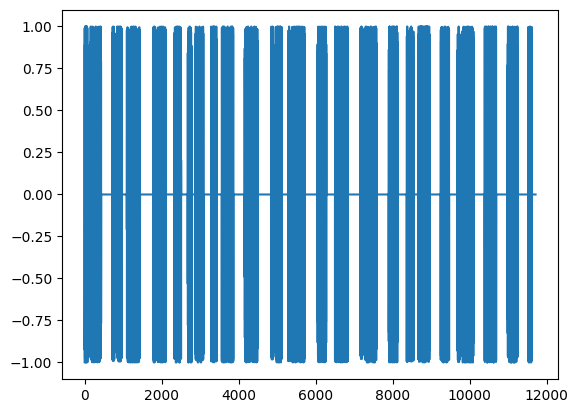

In [200]:
# create the pulse train we are going to send out
train = generate_pulse_train(n_pulses,pulse_durations, receiving_durations, bandwidth, fs)

num_samples = len(train)
total_duration = num_samples / fs

plt.plot(np.real(train))

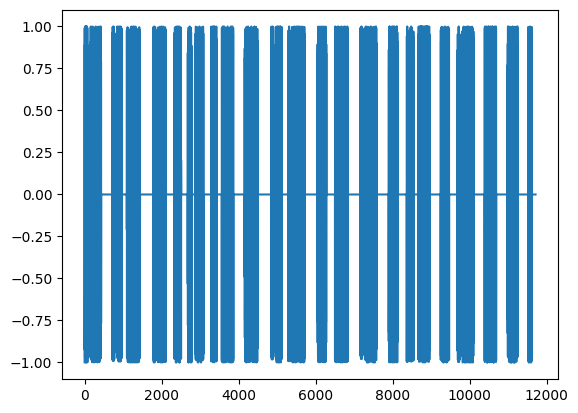

In [201]:
# simulate echoes from targets
echoes = shift_and_delay(ranges, velocities, train, num_samples, total_duration)
plt.plot(np.real(echoes[0]))

In [202]:
coherent_gain = int(np.ceil(total_duration * fs)) * echoes.shape[-2]

coherent_gain_db =  20*torch.log10(torch.Tensor([coherent_gain]))
# doppler processing
RDout = 20 * torch.log10(1E-16 + torch.abs(doppler_processing(echoes,train)))
RDout =  RDout - coherent_gain_db

SNR Loss: 47.590118408203125 dB


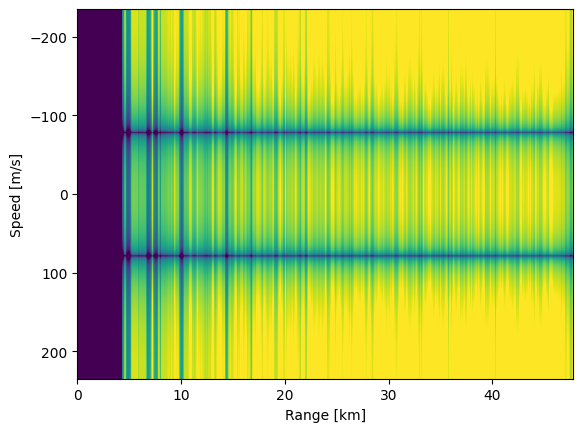

In [203]:
print(f'SNR Loss: {torch.max(RDout)} dB')
plt.imshow(RDout[:,nfft_range//2:].cpu(),aspect='auto',extent=[0,max_unamb_range*1E-3,max_unamb_vel,-max_unamb_vel])
plt.xlabel('Range [km]')
plt.ylabel('Speed [m/s]')
plt.clim(-60,0)